In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/features.csv
/kaggle/input/dataset/sampleSubmission.csv
/kaggle/input/dataset/stores.csv
/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv
/kaggle/input/submission-final/submission.csv


Project Phases:
* Libraries and Data Loading
* Exploratory Analysis and Data Cleaning
* Machine Learning
* Christmas Adjustment

# 1. Libraries and Data Loading 

We will be loading some libraries to make processing easier and some to view the data
libraries used :
* Pandas
* Numpy
* MatPlotLib
* Seaborn
* SciPy
* SkLearn
* PandaSQL
* Warning (ignore any warning we might come across)

In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import pickle # for saving the model



In [67]:
features = pd.read_csv('../input/dataset/features.csv')
train = pd.read_csv('../input/dataset/train.csv')
stores = pd.read_csv('../input/dataset/stores.csv')
test = pd.read_csv('../input/dataset/test.csv')
sample_submission = pd.read_csv('../input/dataset/sampleSubmission.csv')

# 2. Exploratory Analysis and Data Cleaning
* Merging "Features" and "Stores"
* 

In [68]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [69]:
feat_sto.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        NaN        NaN        NaN  211.096358         8.106      False    A   
1        NaN        NaN        NaN  211.242170         8.106       True    A   
2        NaN        NaN        NaN  211.289143         8.106      False    A   
3        NaN        NaN        NaN  211.319643         8.106      False    A   
4        NaN        NaN        NaN  211.350143         8.106      False    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

In [70]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

Type
Store           int64
Date           object
Temperature   float64
Fuel_Price    float64
MarkDown1     float64
MarkDown2     float64
MarkDown3     float64
MarkDown4     float64
MarkDown5     float64
CPI           float64
Unemployment  float64
IsHoliday        bool
Type           object
Size            int64

In [71]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

Type_Train Type_Test
Date             object    object
Dept              int64     int64
IsHoliday          bool      bool
Store             int64     int64
Weekly_Sales    float64       NaN

In [72]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [73]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

In [74]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [75]:
train_detail.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  Week  Year  
0         8.106    A  151315     5  2010  
1         8.106    A  151315     6  2010  
2         8.106    A  151315     7  2010  
3         8.106    A  151315     8  2010  
4         8.106    A  151315     9  2010

In [76]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)


In [77]:
del features, train, stores, test

In [78]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

# null    % null     type
MarkDown2  310322  0.736110  float64
MarkDown4  286603  0.679847  float64
MarkDown3  284479  0.674808  float64
MarkDown1  270889  0.642572  float64
MarkDown5  270138  0.640790  float64

# Holidays Analysis

If, for a certain Week, there are more pre-holiday days in one Year than another, then it is very possible that the Year with more pre-holiday days will have greater Sales for the same Week. So, the model will not take this consideration and we might need to adjust the predicted values at the end.

Another thing to take into account is that Holiday Weeks but with few or no pre-holiday days might have lower Sales than the Week before.



In [79]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

Year  Week   Data_type       Holyday       Day
0   2010     6  Train Data    Super Bowl    Sunday
1   2010    36  Train Data     Labor Day    Monday
2   2010    47  Train Data  Thanksgiving  Thursday
3   2010    52  Train Data     Christmas  Saturday
4   2011     6  Train Data    Super Bowl    Sunday
5   2011    36  Train Data     Labor Day    Monday
6   2011    47  Train Data  Thanksgiving  Thursday
7   2011    52  Train Data     Christmas    Sunday
8   2012     6  Train Data    Super Bowl    Sunday
9   2012    36  Train Data     Labor Day    Monday
10  2012    47   Test Data  Thanksgiving  Thursday
11  2012    52   Test Data     Christmas   Tuesday
12  2013     6   Test Data    Super Bowl    Sunday

## **Observation 1**

* All Holidays fall on the same week
* Christmas has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. The model will not consider more Sales in 2012 for Test Data, so we are going to adjust it at the end, with a formula and an explanation.

# Average Weekly Sales - Per Year

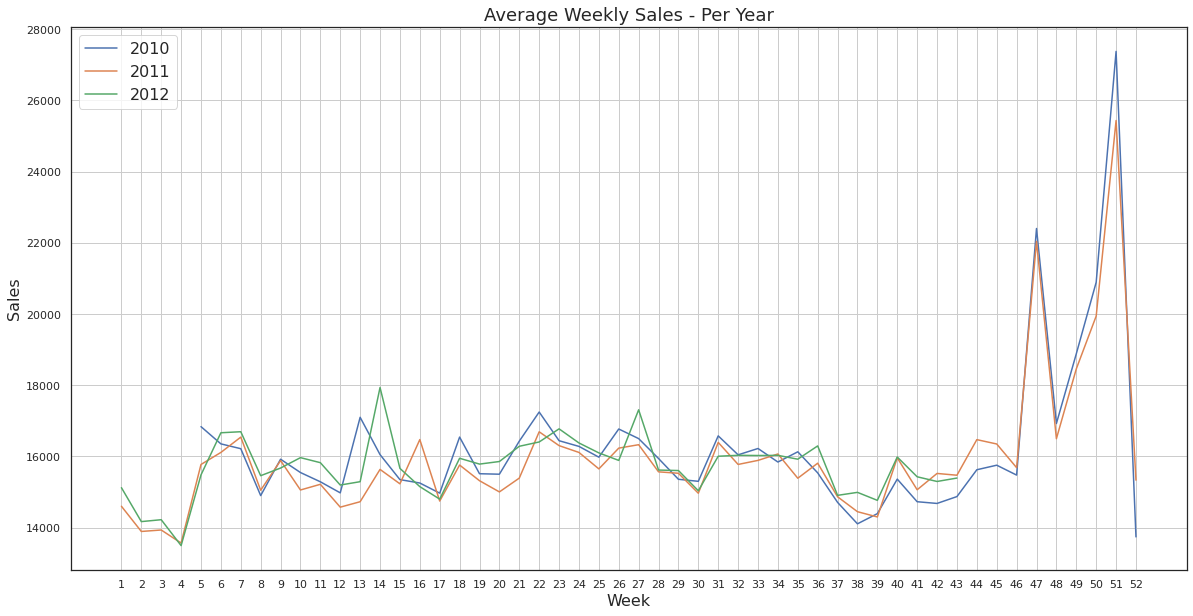

In [80]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,10))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

## Observation 2
As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

In 2010 is in Week 13
In 2011, Week 16
Week 14 in 2012
and, finally, Week 13 in 2013 for Test set
So, we can change to 'True' these Weeks in each Year.

### **Adding Easter**

In [81]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

# Weekly Sales - Mean and Median

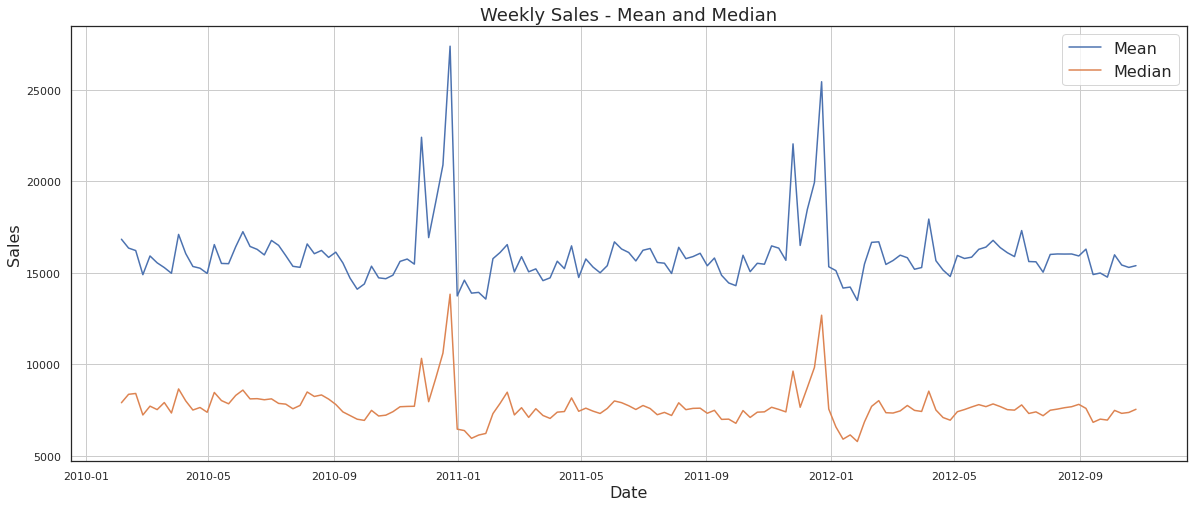

In [82]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

# Average Sales per Store and Department

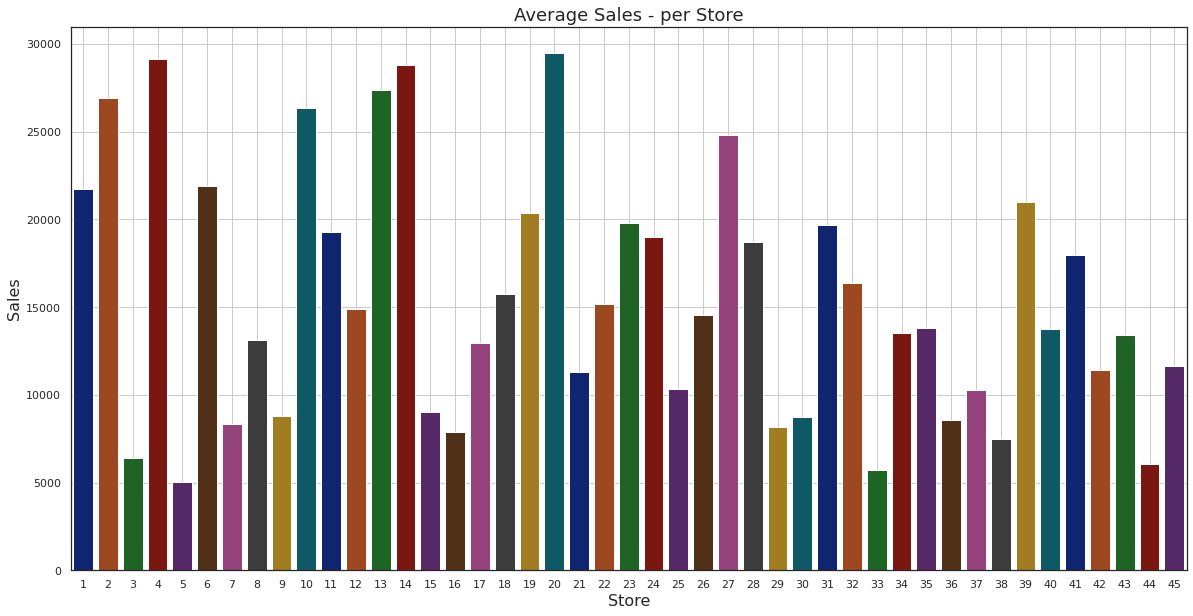

In [83]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,10))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


# Average Sales - Department Wise

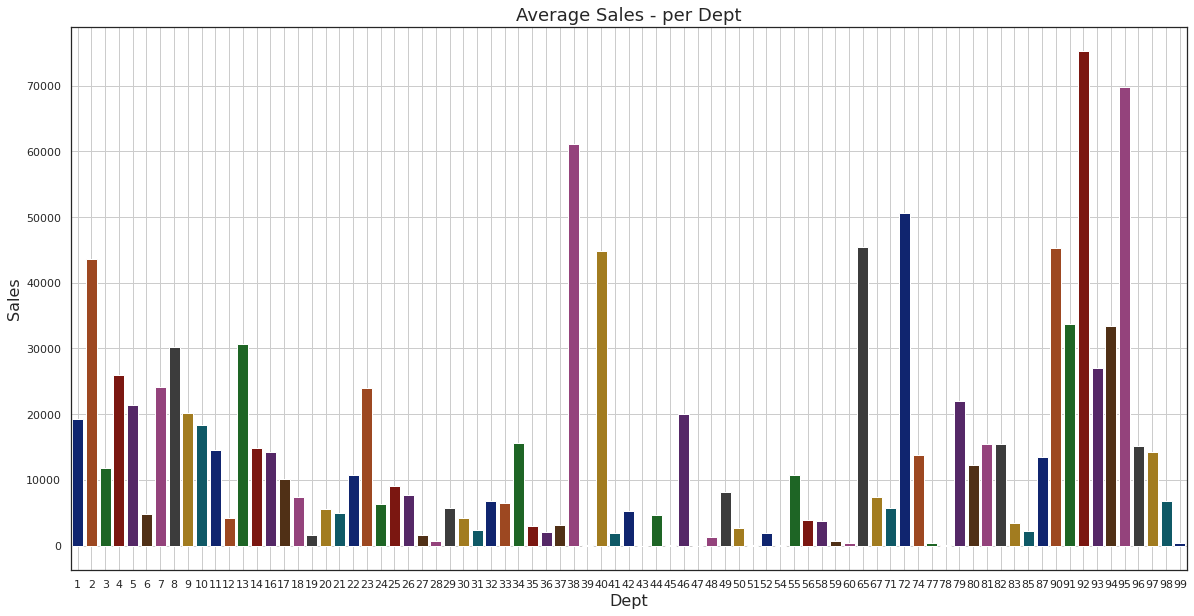

In [84]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(20,10))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

## Obeservation 3
There are Sales difference between the Store and Departments. Also some Depts are not in the list, like number '15', for example.

# Correlation Matrix - Pearson Correlation

Correlation Metrics:

* 0: no correlation at all
* 0-0.3: weak correlation
* 0.3-0.7: moderate correlaton
* 0.7-1: strong correlation

**Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.**

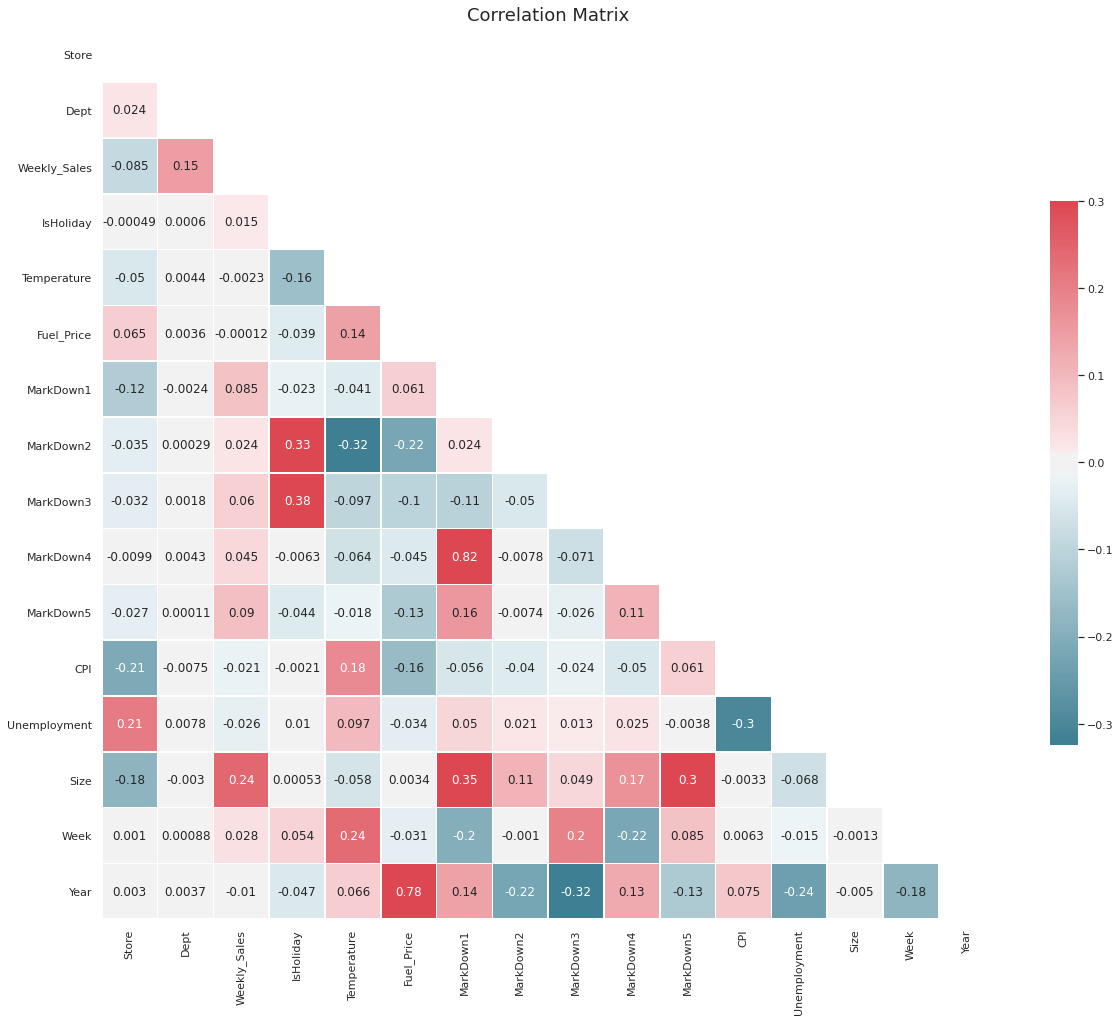

In [85]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Observation 4
'**MarkDown**' 1 to 5 are not strong correlated to '**Weekly_Sales**' and they have a lot of null values, then we can drop them.

Also, '**Fuel_Price**' is strong correlated to '**Year**'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

Other variables that have weak correlation with '**Weekly_Sales**' can be analyzed to see if they are useful.

**Droping Markdown values**

In [86]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

# Analysing Variables
1. BoxPlot and StripPlot for Discrete Variables
2. BoxCox for Continous Variables

In [87]:
def boxplot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [88]:
def boxcox(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

# Weekly Sales vs IsHoliday

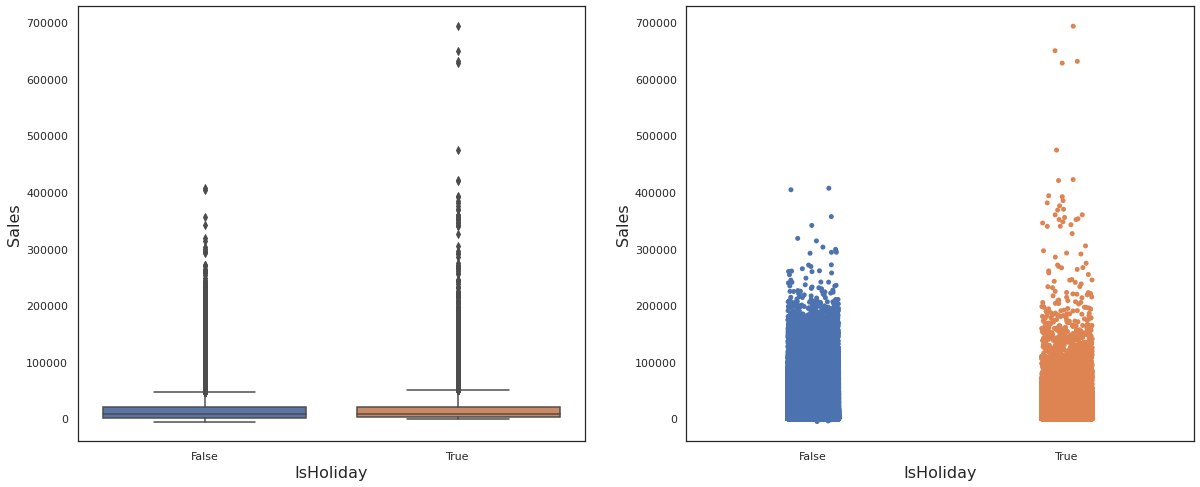

In [89]:
boxplot('IsHoliday')

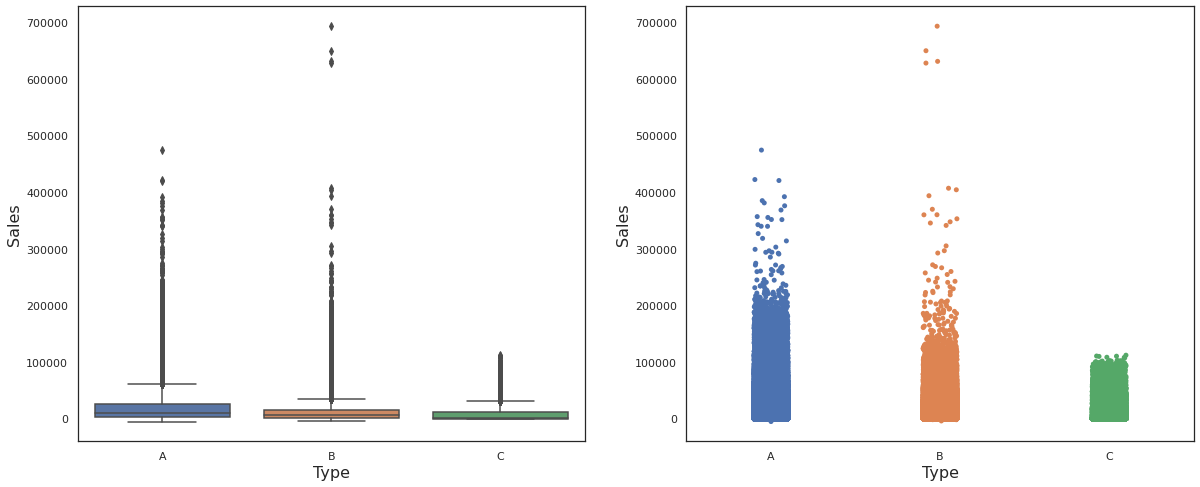

In [90]:
boxplot('Type')

We don't know what 'Type' is, but we can assume that A > B > C in terms of Sales Median. So, let's treat it as an ordinal variable and replace its values.

In [91]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

# Weekly Sales vs Temperature (Continuous)

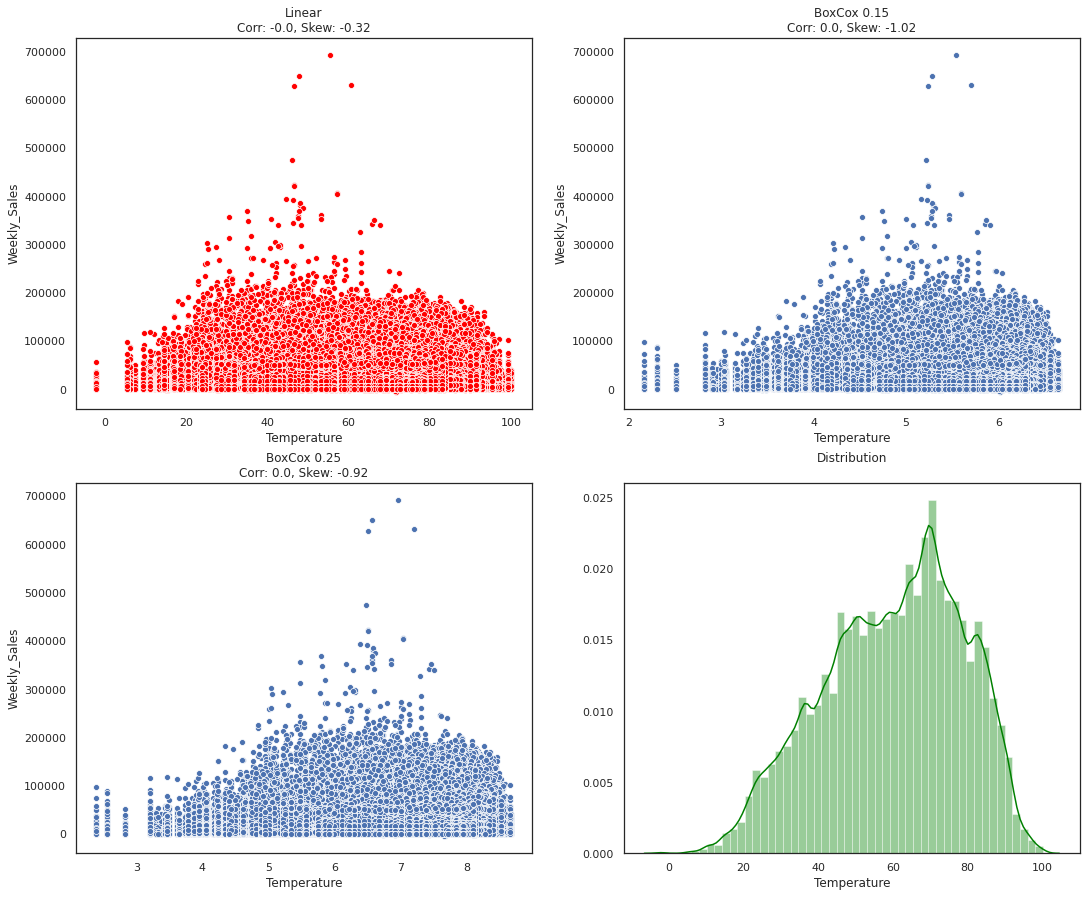

In [92]:
boxcox('Temperature')

The correlations doesn't seem to change at any skewness toh we will drop this feature.

### Droping Temperature

In [93]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

# Weekly Sales vs Unemployement

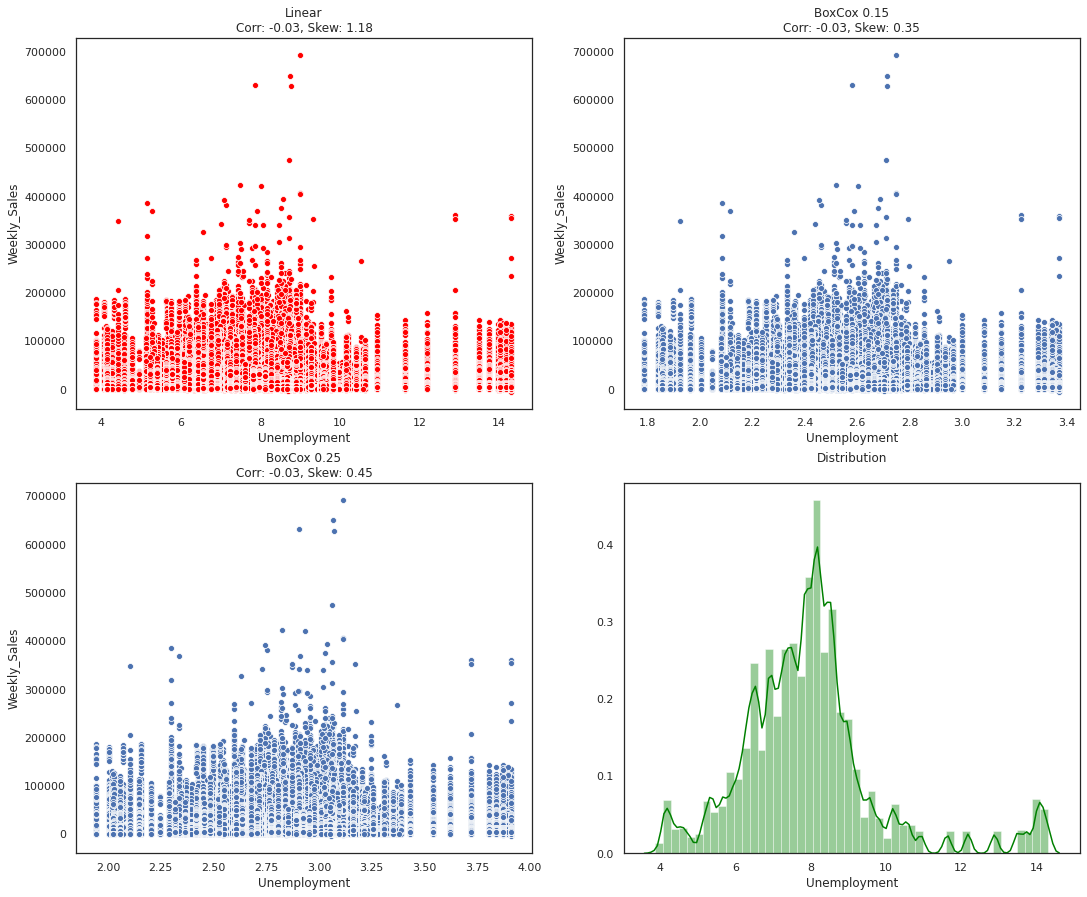

In [94]:
boxcox('Unemployment')

Same for **Unemployment** rate.



In [95]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

# Weekly Sales vs CPI

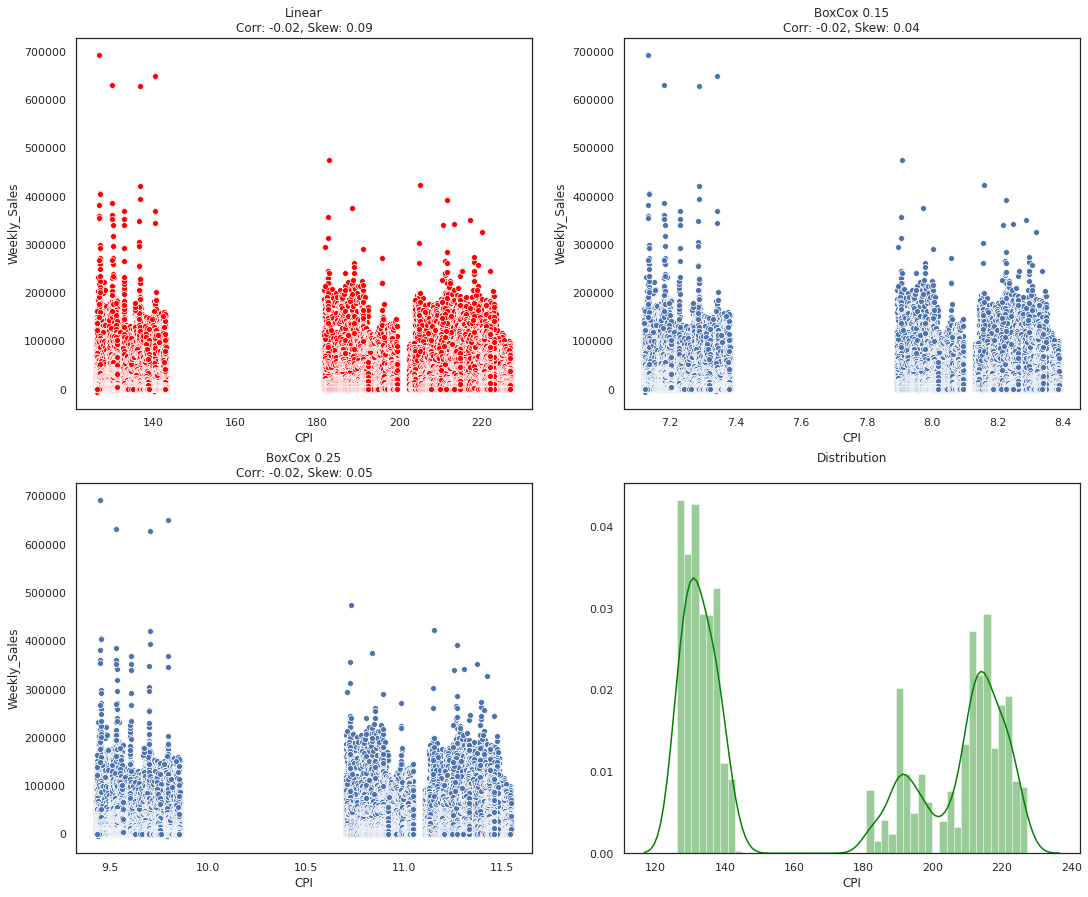

In [96]:
boxcox('CPI')

Same for **CPI**

In [97]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

# Weekly Sales vs Size

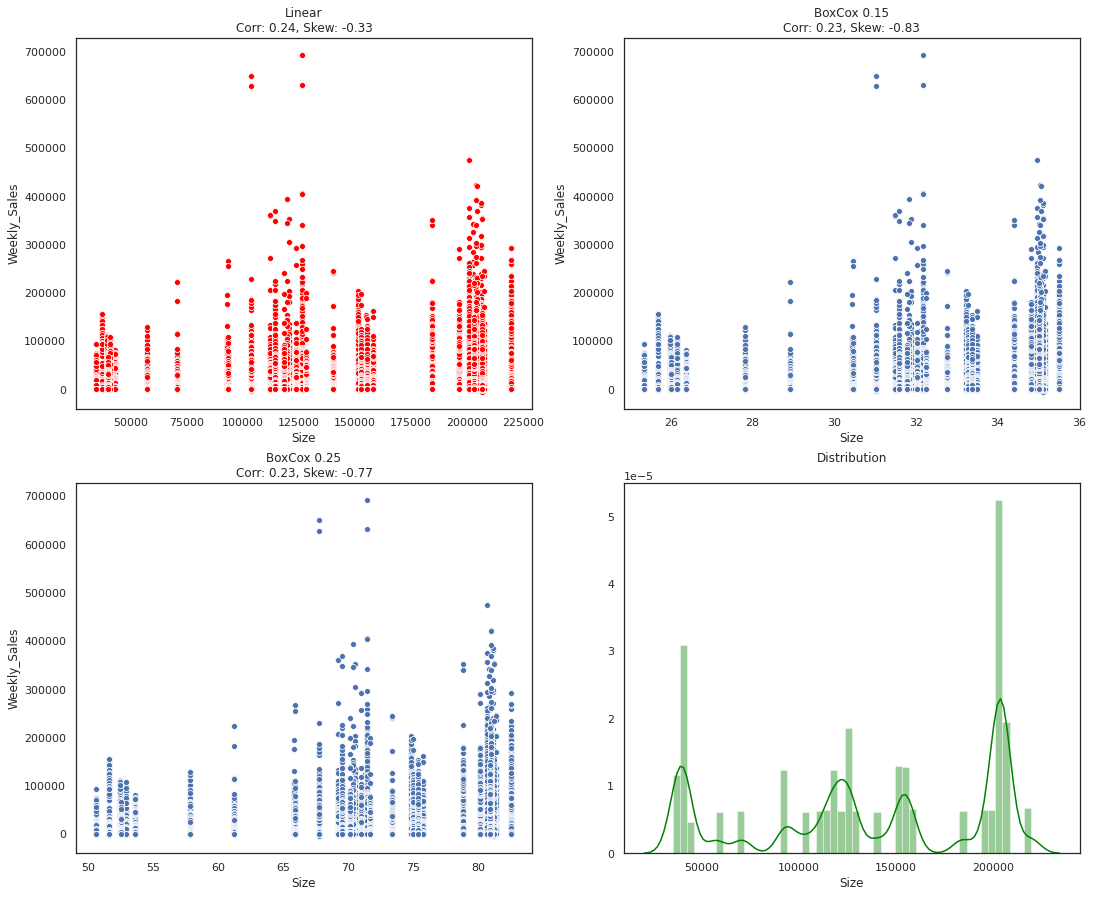

In [98]:
boxcox('Size')

We will continue with this variable, since it has moderate correlation with **WeeklySales**.

# Weighted Mean Average Error Function

In [99]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [100]:
train_detail

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Week  \
0           1     1 2010-02-05      24924.50      False     3  151315     5   
1           1     1 2010-02-12      46039.49       True     3  151315     6   
2           1     1 2010-02-19      41595.55      False     3  151315     7   
3           1     1 2010-02-26      19403.54      False     3  151315     8   
4           1     1 2010-03-05      21827.90      False     3  151315     9   
...       ...   ...        ...           ...        ...   ...     ...   ...   
421565     45    98 2012-09-28        508.37      False     2  118221    39   
421566     45    98 2012-10-05        628.10      False     2  118221    40   
421567     45    98 2012-10-12       1061.02      False     2  118221    41   
421568     45    98 2012-10-19        760.01      False     2  118221    42   
421569     45    98 2012-10-26       1076.80      False     2  118221    43   

        Year  
0       2010  
1       2010  
2       2010  
3       2010  
4       2010  
...      ...  
421565  2012  
421566  2012  
421567  2012  
421568  2012  
421569  2012  

[421570 rows x 9 columns]

In [101]:
test_detail

Store  Dept       Date  IsHoliday  Type    Size  Week  Year
0           1     1 2012-11-02      False     3  151315    44  2012
1           1     1 2012-11-09      False     3  151315    45  2012
2           1     1 2012-11-16      False     3  151315    46  2012
3           1     1 2012-11-23       True     3  151315    47  2012
4           1     1 2012-11-30      False     3  151315    48  2012
...       ...   ...        ...        ...   ...     ...   ...   ...
115059     45    98 2013-06-28      False     2  118221    26  2013
115060     45    98 2013-07-05      False     2  118221    27  2013
115061     45    98 2013-07-12      False     2  118221    28  2013
115062     45    98 2013-07-19      False     2  118221    29  2013
115063     45    98 2013-07-26      False     2  118221    30  2013

[115064 rows x 8 columns]

# Algorithms (Without thinking about efficency)
* After trying different algorithms we concluded that we would get the best results by choosing Random Forest and optimizing

### Errors for Different Models:
   * knn - 
   * Extra Tree - 
   * Random Forest - 
   * Linear Regression - 

In [102]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=60, max_features=3, verbose=1, n_jobs=1)
    return clf
    
def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators = 100, max_features = 'log2', verbose = 1, bootstrap = True)
    return clf

def linear_reg():
    regr = LinearRegression()
    return regr

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
#     return extraTreesRegressor()
    return randomForestRegressor()   
#     return linear_reg()

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

# K-Fold Cross Validation

In [103]:
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in train_detail.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)


In [104]:
splited

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Week  \
0           1     1 2010-02-05      24924.50      False     3  151315     5   
1           1     1 2010-02-12      46039.49       True     3  151315     6   
2           1     1 2010-02-19      41595.55      False     3  151315     7   
3           1     1 2010-02-26      19403.54      False     3  151315     8   
4           1     1 2010-03-05      21827.90      False     3  151315     9   
...       ...   ...        ...           ...        ...   ...     ...   ...   
421269     45    98 2012-09-28        508.37      False     2  118221    39   
421270     45    98 2012-10-05        628.10      False     2  118221    40   
421271     45    98 2012-10-12       1061.02      False     2  118221    41   
421272     45    98 2012-10-19        760.01      False     2  118221    42   
421273     45    98 2012-10-26       1076.80      False     2  118221    43   

        Year  fold  
0       2010   0.0  
1       2010   0.0  
2       2010   0.0  
3       2010   0.0  
4       2010   0.0  
...      ...   ...  
421269  2012   4.0  
421270  2012   4.0  
421271  2012   4.0  
421272  2012   4.0  
421273  2012   4.0  

[421274 rows x 10 columns]

In [105]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    train_detail2 = splited.loc[splited['fold'] != fold]
    test_detail2 = splited.loc[splited['fold'] == fold]
    train_y = train_detail2['Weekly_Sales']
    train_x = train_detail2[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
    test_y = test_detail2['Weekly_Sales']
    test_x = test_detail2[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
    print(train_detail2.shape, test_detail2.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
#     weights = test_x['isHoliday'].replace(True, 5).replace(False, 1)
#     error = calculate_error(test_y, predicted, weights)
    error = WMAE(test_x, test_y, predicted)
    print(error)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 10) (85552, 10)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


3737.96
0 3737.96
Find best model
(335849, 10) (85425, 10)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


3925.37
1 3925.37
(335970, 10) (85304, 10)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


3901.43
2 3901.43
(338733, 10) (82541, 10)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


3851.2
3 3851.2
(338822, 10) (82452, 10)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3642.53
4 3642.53
Find best model


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [106]:
error_cv # Average Error

3811.6979999999994

In [107]:
best_error #least error

3642.53

# Random Forest (Split into 3 parts for optimizing)

In [108]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [109]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [110]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

# Training Model

In [111]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

# Tuning

### Tuning n_estimators and max_depth

Tuning 'n_estimators' and 'max_depth'.

Here, it is possible to test a lot of values. These are the final ones, after a bit of testing.

In [112]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

# random_forest(n_estimators, max_depth)

The result based on WAME \
Max_Depth - 30 \
Estimators - 56

### Tuning max_features

In [113]:
max_features = [2, 3, 4, 5, 6, 7]

# random_forest_II(n_estimators=56, max_depth=30, max_features=max_features)

Max_Feature - 6

### Tuning min_samples_spilt and min_samples_leaf

In [114]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

# random_forest_III(n_estimators=56, max_depth=30, max_features=6, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Min_Samples_Leaf - 1 \
Min_Samples_Split - 3

# Final Fitting

In [115]:
RF = RandomForestRegressor(n_estimators=56, max_depth=30, max_features=6, min_samples_split=4, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=30, max_features=6, min_samples_split=4,
                      n_estimators=56)

# Saving the Model

In [116]:
model_save_file = open("SavedModel.sav", 'wb')
pickle.dump(RF, model_save_file)
model_save_file.close()

# Loading the Model

In [117]:
load_saved_model_file = open('SavedModel.sav', 'rb')
loaded_model = pickle.load(load_saved_model_file)
load_saved_model_file.close()

## Predicting on the loaded model

In [118]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
loaded_predict = loaded_model.predict(X_test)

# Predictions

In [119]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

In [120]:
print(np.all(loaded_predict==predict)) # to show that saved model is loading perfectly by comparing the predictions
# True if all elements are equal, False otherwise.

True


In [121]:
sample_submission['Weekly_Sales'] = loaded_predict

In [122]:
sample_submission

Id  Weekly_Sales
0         1_1_2012-11-02  31459.205141
1         1_1_2012-11-09  19662.729076
2         1_1_2012-11-16  19582.365085
3         1_1_2012-11-23  19495.622925
4         1_1_2012-11-30  24476.449498
...                  ...           ...
115059  45_98_2013-06-28    679.690421
115060  45_98_2013-07-05    681.656374
115061  45_98_2013-07-12    682.689266
115062  45_98_2013-07-19    743.961625
115063  45_98_2013-07-26    713.974131

[115064 rows x 2 columns]

In [123]:
sample_submission.to_csv('Submission.csv', index=False)

# Error(WMAE) on Walmart's testing data (hidden)
# 2776.28705

In [124]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(sample_submission)